# Understanding the Impact of Pre-Processing Text on Rotten Tomato Reviews

this is the testing notebook. the training notebook can be found here https://colab.research.google.com/drive/1lxcvMShKN8mwTWsQr7zS-Izg8KVNt7Km#scrollTo=CzLFPaTxrmou

## Installing Libraries

In [ ]:
#not all of these were needed but were used for testing at somepoint

#!pip install pandas==2.0.3
!pip install scipy==1.13.0
#!pip install matplotlib==3.8.4
#!pip install seaborn==0.13.2
#!pip install scikit-learn==1.4.0
#!pip install torch==2.2.1
#!pip install skorch==0.15.0
#!pip install joblib==1.4.0
#!pip install tensorflow==2.15
#!pip install nltk==3.8.1
#!pip install spacy==3.7.4
#!python -m spacy download en_core_web_sm
#!pip install transformers==4.40.1
!pip install datasets==2.19.0
!pip install nltk contractions==0.1.73

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0


Importing Packages

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import string
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
import contractions
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse.linalg
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCVz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
import joblib
from joblib import dump
from joblib import load
from nltk.stem import PorterStemmer
from transformers import pipeline
from sklearn.decomposition import TruncatedSVD

Downloading packages

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Loading and Preprocessing The Data and Loading the Models

you will need to manually upload the job lib files and wait for the dials at the bottom left to complete and disappaer to have the full models loaded up

In [ ]:
#loading the models and the data

rt_data = load_dataset("rotten_tomatoes")

rt_df3 = pd.DataFrame(rt_data['test'])
rt_df_test = rt_df3.copy()

svm_classifier = load('final_svm_classifier.joblib')
mlp_classifier = load('final_mlp_classifier.joblib')

In [ ]:
from transformers import pipeline
bert_classifier = pipeline(model='distilbert-base-uncased-finetuned-sst-2-english')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
#loading the vectorizer used on the training data

vectorizer = load('stem_tfidf_uni_vectorizer.joblib')

In [ ]:
#creating the preprocessing
#taken from training notebook

def review_preprocessing(reviews):

  #fixing contractions
  reviews = contractions.fix(reviews)

  #converts to lower case
  reviews = reviews.lower()

  #tokenise before removing punctuation so that words like can't dont get messed up
  #initally i did not do this and got some wonky results
  #then removing the punctuation from the tokens
  #then removing stop words
  tokens = word_tokenize(reviews)
  tokens_table = str.maketrans('', '', string.punctuation)
  no_punctuation_tokens = [words.translate(tokens_table) for words in tokens]

  #removing stop words by filtering out the stop words and joining them back
  stop_words = set(stopwords.words('english'))
  #adding an additional check in the filter since we are removing stop words from tokens from which we have removed punctuation which could retun ' '
  filter = [words for words in no_punctuation_tokens if words not in stop_words and words != '']
  reviews = ' '.join(filter)

  return reviews

In [ ]:
#applying the preprocessing

rt_df_test['preprocessed_text'] = rt_df_test['text'].apply(review_preprocessing)

In [ ]:
#creating the stemmer for additional processing
#taken from training notebook

stemmer = PorterStemmer()

def get_stem(reviews):
    tokens = word_tokenize(reviews)
    reviews_stems = [stemmer.stem(token) for token in tokens]
    return ' '.join(reviews_stems)

In [ ]:
#completing the stemming and vectorization for svm and mlp
#since we are using pre trained vectors, we do not fit transform but simply transform
#documentation: https://datascience.stackexchange.com/questions/75749/valueerror-x-has-3-features-per-sample-expecting-1500

rt_df_test_stem = rt_df_test.copy()

rt_df_test_stem['text_preprocessed_stem'] = rt_df_test_stem['preprocessed_text'].apply(get_stem)

vectorizer = vectorizer

X_stem_tfidf_uni = vectorizer.transform(rt_df_test_stem['text_preprocessed_stem'])
y_stem_tfidf_uni = rt_df_test_stem['label']
X_stem_tfidf_uni

<1066x13645 sparse matrix of type '<class 'numpy.float64'>'
	with 10396 stored elements in Compressed Sparse Row format>

## Getting Predictions and Metrics

we are getting the classification reports, confusion matrices and auc-roc curves

In [ ]:
#getting the predictions

svm_predictions = svm_classifier.predict(X_stem_tfidf_uni)
mlp_predictions = mlp_classifier.predict(X_stem_tfidf_uni)

In [ ]:
#making the bert model and getting accuracy just as a comparison
#bert not using the stemmed or vectorized data as svm or mlp

rt_df_test_bert = rt_df_test.copy()

rt_df_test_bert['bert_label'] = rt_df_test_bert['text'].apply(lambda x: bert_classifier(x)[0]['label'])

rt_df_test_bert['bert_label'] = rt_df_test_bert['bert_label'].map({'POSITIVE': 1, 'NEGATIVE': 0})
bert_accuracy_test_set = accuracy_score(rt_df_test_bert['label'], rt_df_test_bert['bert_label'])
bert_accuracy_test_set

#accuracy is high as expected

0.8058161350844277

In [ ]:
#creating classification reports which will hold our results

#svm classification report
svm_report = classification_report(y_stem_tfidf_uni, svm_predictions, target_names=['Negative (0)', 'Positive (1)'])

#mlp classification report
mlp_report = classification_report(y_stem_tfidf_uni, mlp_predictions, target_names=['Negative (0)', 'Positive (1)'])

print('SVM Classifier Report:\n', svm_report)
print('--------------\n')
print('MLP Classifier Report:\n', mlp_report)

#accuracy has improved on the testing set meaning the base models have generalized well
#the accuracy is also not far off bert
#some deeper hyper parameter tuning will likely make the models much better

SVM Classifier Report:
               precision    recall  f1-score   support

Negative (0)       0.77      0.80      0.78       533
Positive (1)       0.79      0.76      0.77       533

    accuracy                           0.78      1066
   macro avg       0.78      0.78      0.78      1066
weighted avg       0.78      0.78      0.78      1066

--------------

MLP Classifier Report:
               precision    recall  f1-score   support

Negative (0)       0.76      0.83      0.79       533
Positive (1)       0.81      0.74      0.77       533

    accuracy                           0.78      1066
   macro avg       0.78      0.78      0.78      1066
weighted avg       0.78      0.78      0.78      1066



In [ ]:
#creating confusion matrices

#svm matrix
svm_confusion_matrix = confusion_matrix(y_stem_tfidf_uni, svm_predictions)

#mlp matrix
mlp_confusion_matrix = confusion_matrix(y_stem_tfidf_uni, mlp_predictions)

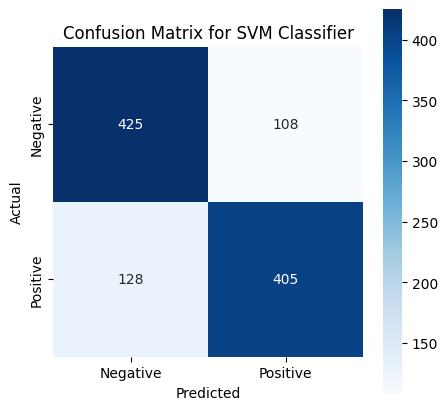

In [ ]:
#svm plot
#documentation: https://seaborn.pydata.org/generated/seaborn.heatmap.html

plt.figure(figsize=(5,5))
sns.heatmap(svm_confusion_matrix, annot=True, fmt="d", square=True, cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for SVM Classifier')
plt.show()

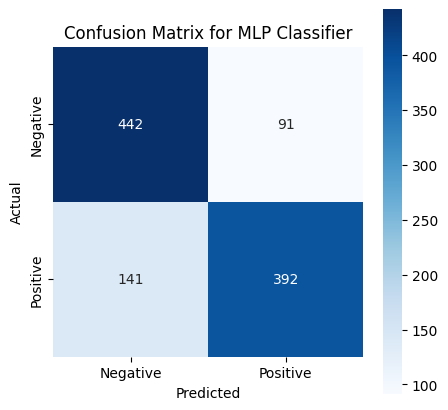

In [ ]:
#mlp plot
#documentation: https://seaborn.pydata.org/generated/seaborn.heatmap.html

plt.figure(figsize=(5,5))
sns.heatmap(mlp_confusion_matrix, annot=True, fmt="d", square=True, cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()

In [ ]:
#getting the auc values to plot
#worked on this during neural networks course so was able to work through shape problems pretty quick

svm_probabilities = svm_classifier.predict_proba(X_stem_tfidf_uni)
mlp_probabilities = mlp_classifier.predict_proba(X_stem_tfidf_uni)

svm_probabilities = np.squeeze(svm_probabilities)
mlp_probabilities = np.squeeze(mlp_probabilities)

svm_probabilities = svm_probabilities[:, 1]
mlp_probabilities = mlp_probabilities[:, 1]

y_ravel = y_stem_tfidf_uni.ravel()

fpr_svm, tpr_svm, _ = roc_curve(y_ravel, svm_probabilities)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_mlp, tpr_mlp, _ = roc_curve(y_ravel, mlp_probabilities)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

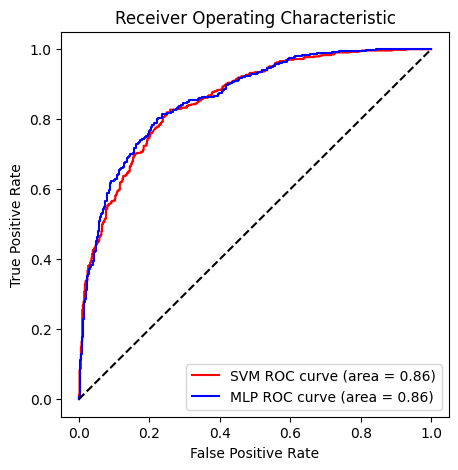

In [ ]:
#auc curve

plt.figure(figsize=(5, 5))

#svm
plt.plot(fpr_svm, tpr_svm, color='red', label='SVM ROC curve (area = %0.2f)' % roc_auc_svm)

#mlp
plt.plot(fpr_mlp, tpr_mlp, color='blue', label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp)

#50% line
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#the aucs are quite high meaning that there is probably a different threshold that we can use during the sentiment classification that will result in higher accuracy
#this seems to make sense given the sentiment scores we got during eda in the training notebook
#as a reminder the scores were like the following
#Average Compound Score for Positive Reviews: 0.33
#Average Compound Score for Negative Reviews: 0.04
#Median Compound Score for Positive Reviews: 0.44
#Median Compound Score for Negative Reviews: 0.00
#the non negativity of the negative scores is likely causing some confusion
#we might see sentences that sound postive but are actually negative being misclassified

## Some deeper error analysis on misclassified sentences

In [ ]:
#adding 2 new columns to the dataframe

rt_df_test_stem['svm_predicted'] = svm_predictions
rt_df_test_stem['mlp_predicted'] = mlp_predictions

In [ ]:
#rearranging the data frame so it makes sense

columns = list(rt_df_test_stem.columns)
#['text', 'label', 'text_preprocessed_stem', 'preprocessed_text', 'svm_predicted', 'mlp_predicted']

order = [columns[0], columns[3], columns[2], columns[1], columns[4], columns[5]]
rt_df_test_stem = rt_df_test_stem[order]

rt_df_test_stem.head(5)
#columns

,text,preprocessed_text,text_preprocessed_stem,label,svm_predicted,mlp_predicted
0,"lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .",lovingly photographed manner golden book sprung life stuart little 2 manages sweetness largely without stickiness,lovingli photograph manner golden book sprung life stuart littl 2 manag sweet larg without sticki,1,1,1
1,consistently clever and suspenseful .,consistently clever suspenseful,consist clever suspens,1,1,1
2,"it's like a "" big chill "" reunion of the baader-meinhof gang , only these guys are more harmless pranksters than political activists .",like big chill reunion baadermeinhof gang guys harmless pranksters political activists,like big chill reunion baadermeinhof gang guy harmless prankster polit activist,1,1,1
3,"the story gives ample opportunity for large-scale action and suspense , which director shekhar kapur supplies with tremendous skill .",story gives ample opportunity largescale action suspense director shekhar kapur supplies tremendous skill,stori give ampl opportun largescal action suspens director shekhar kapur suppli tremend skill,1,1,1
4,"red dragon "" never cuts corners .",red dragon never cuts corners,red dragon never cut corner,1,0,0


In [ ]:
#setting the view options to see all the text
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [ ]:
#creating data frame combinations of true labels and predicted labels displaying only the first 10 rows

#label is 1, svm predicted 1, and mlp predicted 1
df_label1_svm1_mlp1 = rt_df_test_stem[(rt_df_test_stem['label'] == 1) &
                                     (rt_df_test_stem['svm_predicted'] == 1) &
                                     (rt_df_test_stem['mlp_predicted'] == 1)].head(10)

#label is 1, svm predicted 0, and mlp predicted 1
df_label1_svm0_mlp1 = rt_df_test_stem[(rt_df_test_stem['label'] == 1) &
                                     (rt_df_test_stem['svm_predicted'] == 0) &
                                     (rt_df_test_stem['mlp_predicted'] == 1)].head(10)

#label is 1, svm predicted 1, and mlp predicted 0
df_label1_svm1_mlp0 = rt_df_test_stem[(rt_df_test_stem['label'] == 1) &
                                     (rt_df_test_stem['svm_predicted'] == 1) &
                                     (rt_df_test_stem['mlp_predicted'] == 0)].head(10)

#label is 1, svm predicted 0, and mlp predicted 0
df_label1_svm0_mlp0 = rt_df_test_stem[(rt_df_test_stem['label'] == 1) &
                                     (rt_df_test_stem['svm_predicted'] == 0) &
                                     (rt_df_test_stem['mlp_predicted'] == 0)].head(10)

#label is 0, svm predicted 1, and mlp predicted 1
df_label0_svm1_mlp1 = rt_df_test_stem[(rt_df_test_stem['label'] == 0) &
                                     (rt_df_test_stem['svm_predicted'] == 1) &
                                     (rt_df_test_stem['mlp_predicted'] == 1)].head(10)

#label is 0, svm predicted 0, and mlp predicted 1
df_label0_svm0_mlp1 = rt_df_test_stem[(rt_df_test_stem['label'] == 0) &
                                     (rt_df_test_stem['svm_predicted'] == 0) &
                                     (rt_df_test_stem['mlp_predicted'] == 1)].head(10)

#label is 0, svm predicted 1, and mlp predicted 0
df_label0_svm1_mlp0 = rt_df_test_stem[(rt_df_test_stem['label'] == 0) &
                                     (rt_df_test_stem['svm_predicted'] == 1) &
                                     (rt_df_test_stem['mlp_predicted'] == 0)].head(10)

#label is 0, svm predicted 0, and mlp predicted 0
df_label0_svm0_mlp0 = rt_df_test_stem[(rt_df_test_stem['label'] == 0) &
                                     (rt_df_test_stem['svm_predicted'] == 0) &
                                     (rt_df_test_stem['mlp_predicted'] == 0)].head(10)

In [ ]:
df_label0_svm1_mlp1

,text,preprocessed_text,text_preprocessed_stem,label,svm_predicted,mlp_predicted
544,a film without surprise geared toward maximum comfort and familiarity .,film without surprise geared toward maximum comfort familiarity,film without surpris gear toward maximum comfort familiar,0,1,1
545,"fessenden continues to do interesting work , and it would be nice to see what he could make with a decent budget . but the problem with wendigo , for all its effective moments , isn't really one of resources .",fessenden continues interesting work would nice see could make decent budget problem wendigo effective moments really one resources,fessenden continu interest work would nice see could make decent budget problem wendigo effect moment realli one resourc,0,1,1
546,"spirit is a visual treat , and it takes chances that are bold by studio standards , but it lacks a strong narrative .",spirit visual treat takes chances bold studio standards lacks strong narrative,spirit visual treat take chanc bold studio standard lack strong narr,0,1,1
548,"this is a children's film in the truest sense . it's packed with adventure and a worthwhile environmental message , so it's great for the kids . parents , on the other hand , will be ahead of the plot at all times , and there isn't enough clever innuendo to fil",children film truest sense packed adventure worthwhile environmental message great kids parents hand ahead plot times enough clever innuendo fil,children film truest sens pack adventur worthwhil environment messag great kid parent hand ahead plot time enough clever innuendo fil,0,1,1
554,"what ensues are much blood-splattering , mass drug-induced bowel evacuations , and none-too-funny commentary on the cultural distinctions between americans and brits .",ensues much bloodsplattering mass druginduced bowel evacuations nonetoofunny commentary cultural distinctions americans brits,ensu much bloodsplatt mass druginduc bowel evacu nonetoofunni commentari cultur distinct american brit,0,1,1
559,"sandra bullock and hugh grant make a great team , but this predictable romantic comedy should get a pink slip .",sandra bullock hugh grant make great team predictable romantic comedy get pink slip,sandra bullock hugh grant make great team predict romant comedi get pink slip,0,1,1
580,a wannabe comedy of manners about a brainy prep-school kid with a mrs . robinson complex founders on its own preciousness -- and squanders its beautiful women .,wannabe comedy manners brainy prepschool kid mrs robinson complex founders preciousness squanders beautiful women,wannab comedi manner braini prepschool kid mr robinson complex founder precious squander beauti women,0,1,1
587,"the connected stories of breitbart and hanussen are actually fascinating , but the filmmaking in invincible is such that the movie does not do them justice .",connected stories breitbart hanussen actually fascinating filmmaking invincible movie justice,connect stori breitbart hanussen actual fascin filmmak invinc movi justic,0,1,1
588,"a depressingly retrograde , 'post-feminist' romantic comedy that takes an astonishingly condescending attitude toward women .",depressingly retrograde postfeminist romantic comedy takes astonishingly condescending attitude toward women,depressingli retrograd postfeminist romant comedi take astonishingli condescend attitud toward women,0,1,1
589,"return to never land is much more p . c . than the original version ( no more racist portraits of indians , for instance ) , but the excitement is missing .",return never land much p c original version racist portraits indians instance excitement missing,return never land much p c origin version racist portrait indian instanc excit miss,0,1,1


In [ ]:
df_label1_svm0_mlp0

,text,preprocessed_text,text_preprocessed_stem,label,svm_predicted,mlp_predicted
4,"red dragon "" never cuts corners .",red dragon never cuts corners,red dragon never cut corner,1,0,0
7,weighty and ponderous but every bit as filling as the treat of the title .,weighty ponderous every bit filling treat title,weighti ponder everi bit fill treat titl,1,0,0
9,generates an enormous feeling of empathy for its characters .,generates enormous feeling empathy characters,gener enorm feel empathi charact,1,0,0
12,"mostly , [goldbacher] just lets her complicated characters be unruly , confusing and , through it all , human .",mostly goldbacher let us complicated characters unruly confusing human,mostli goldbach let us complic charact unruli confus human,1,0,0
18,"as it turns out , you can go home again .",turns go home,turn go home,1,0,0
19,"you've already seen city by the sea under a variety of titles , but it's worth yet another visit .",already seen city sea variety titles worth yet another visit,alreadi seen citi sea varieti titl worth yet anoth visit,1,0,0
22,"grown-up quibbles are beside the point here . the little girls understand , and mccracken knows that's all that matters .",grownup quibbles beside point little girls understand mccracken knows matters,grownup quibbl besid point littl girl understand mccracken know matter,1,0,0
28,"devotees of star trek ii : the wrath of khan will feel a nagging sense of deja vu , and the grandeur of the best next generation episodes is lacking .",devotees star trek ii wrath khan feel nagging sense deja vu grandeur best next generation episodes lacking,devote star trek ii wrath khan feel nag sens deja vu grandeur best next gener episod lack,1,0,0
30,what's so striking about jolie's performance is that she never lets her character become a caricature -- not even with that radioactive hair .,striking jolie performance never let us character become caricature even radioactive hair,strike joli perform never let us charact becom caricatur even radioact hair,1,0,0
31,"the main story . . . is compelling enough , but it's difficult to shrug off the annoyance of that chatty fish .",main story compelling enough difficult shrug annoyance chatty fish,main stori compel enough difficult shrug annoy chatti fish,1,0,0
